In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [4]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt', sep = '\t')
immune_classes.rename(columns = {'Unnamed: 0':'t_ind'}, inplace = True)

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:

covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_europe  = covid_data[covid_data['location'] == 'Europe']

In [7]:
clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/clade_stats_SARS-CoV-2'
assert os.path.exists(clade_stats_SARS_CoV_2_folder)

clade_statistics_SARS_CoV_2_Europe = pd.read_csv(clade_stats_SARS_CoV_2_folder+'/clade_statistics_Europe.tsv', sep = '\t')

In [8]:
last_date = '2022-06-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_Europe  = covid_data[covid_data['location'] == 'Europe'].query(f'date < "{last_date}"')
clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/clade_stats_SARS-CoV-2'
assert os.path.exists(clade_stats_SARS_CoV_2_folder)

clade_statistics_SARS_CoV_2_Europe = pd.read_csv(clade_stats_SARS_CoV_2_folder+'/clade_statistics_Europe.tsv', sep = '\t')
clade_statistics_SARS_CoV_2_Europe = clade_statistics_SARS_CoV_2_Europe.query(f'Time < "{last_date}"')

In [9]:
x_origination_times = []
xmin_vals =[0]+ list(np.logspace(-7,-1,10))
for xmin in tqdm(xmin_vals ):
    x_mini_df  = clade_statistics_SARS_CoV_2_Europe.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    x_origination_times.append(x_mini_df)

#concatenate with column names time_xmin
x_origination_times = pd.concat(x_origination_times,axis=1)
x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]

100%|██████████| 11/11 [00:00<00:00, 28.85it/s]


In [10]:
reference_date = pd.to_datetime('2020-01-01')
x_origination_times.reset_index(inplace=True)

for xmin in xmin_vals:
    x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(x_origination_times[f'time_{xmin:.1e}'])
    x_origination_times[f'day_diff_{xmin:.1e}'] = x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date

In [11]:
count_thresh = []
for xmin in xmin_vals:
    dcol = x_origination_times[f'day_diff_{xmin:.1e}']
    print(xmin, dcol[~np.isnan(dcol)].count())
    count_thresh.append(dcol[~np.isnan(dcol)].count())

   

0 3423
1e-07 3255
4.641588833612782e-07 3233
2.1544346900318822e-06 3191
1e-05 3183
4.641588833612772e-05 3133
0.00021544346900318823 1941
0.001 397
0.004641588833612773 71
0.021544346900318822 33
0.1 24


/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_10593/2812642458.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(xmin_vals,1/xmin_vals)


Text(0.5, 0.98, 'Number of clades with frequency above threshold, Europe')

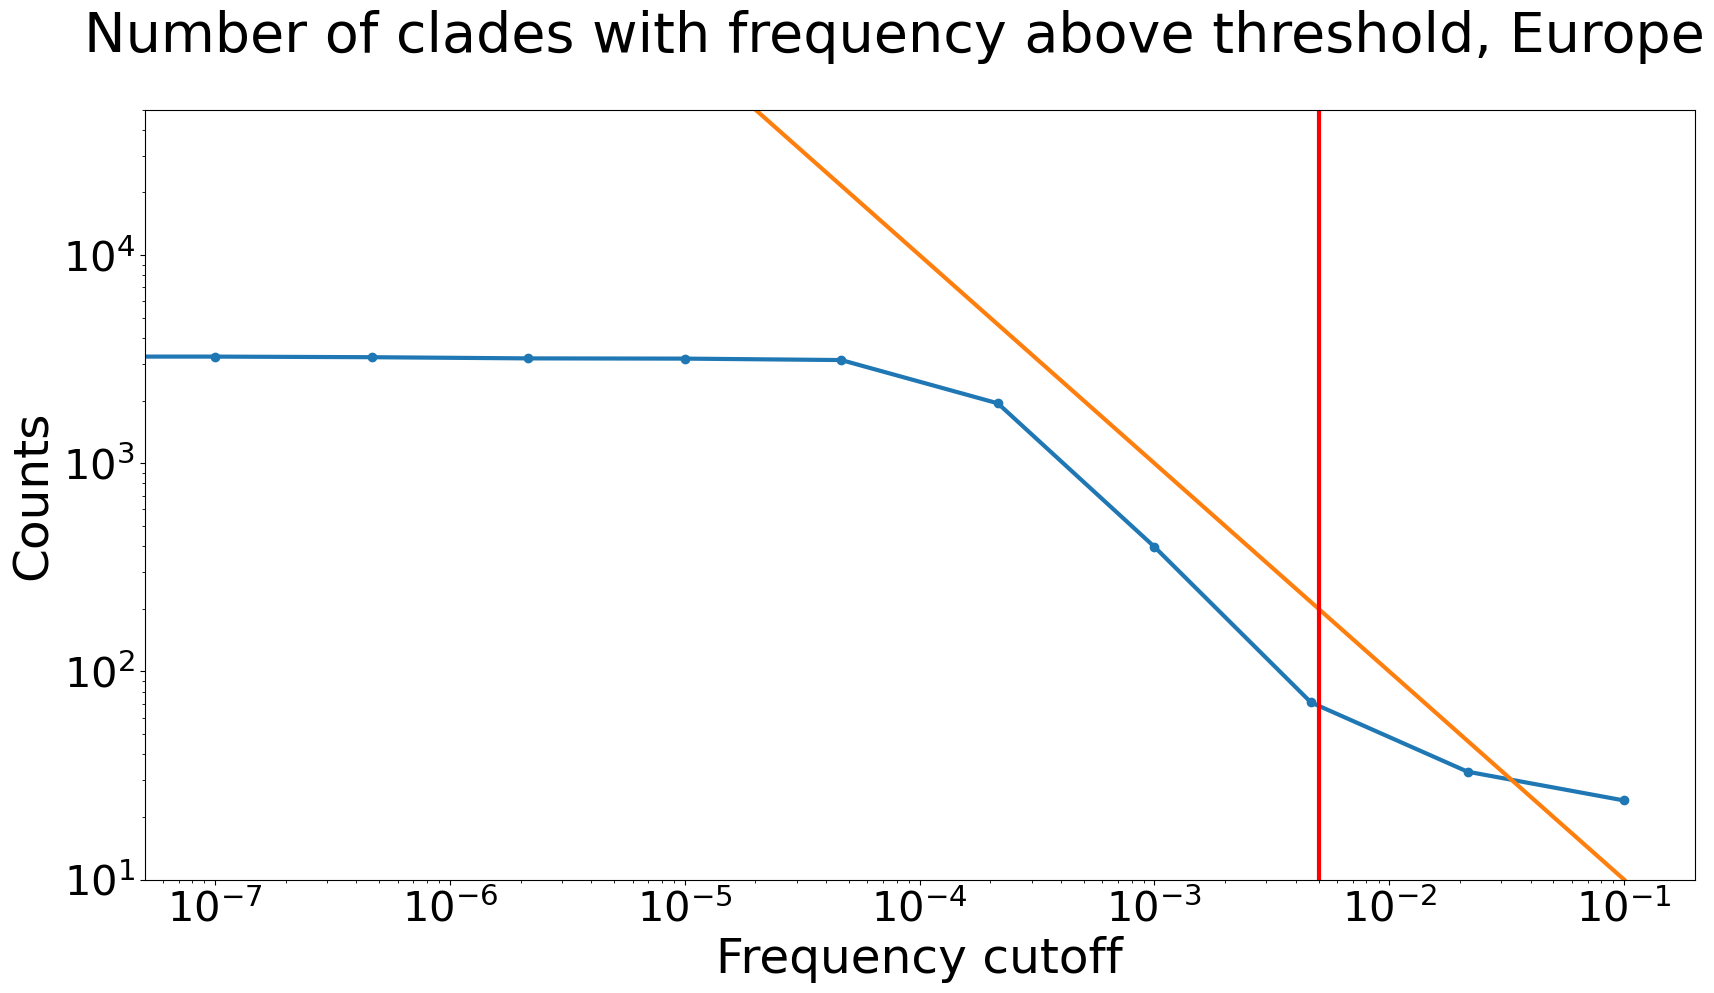

In [12]:
xmin_vals = np.array(xmin_vals)
fig,ax= plt.subplots(1,1,figsize=(20,10))
ax.plot(xmin_vals,count_thresh,marker='o')
ax.plot(xmin_vals,1/xmin_vals)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency cutoff')
ax.set_ylabel('Counts')

ax.set_ylim(bottom=1e1,top=5e4)
ax.axvline(x = 5e-3,color='r')
fig.suptitle('Number of clades with frequency above threshold, Europe')


In [13]:
b,h= np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7))

In [14]:
covid_data_europe

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
108233,OWID_EUR,NaN,Europe,2020-01-05,1.0,1.0,NaN,3.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
108234,OWID_EUR,NaN,Europe,2020-01-06,1.0,0.0,NaN,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
108235,OWID_EUR,NaN,Europe,2020-01-07,1.0,0.0,NaN,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
108236,OWID_EUR,NaN,Europe,2020-01-08,1.0,0.0,NaN,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
108237,OWID_EUR,NaN,Europe,2020-01-09,1.0,0.0,NaN,3.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109787,OWID_EUR,NaN,Europe,2024-04-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
109788,OWID_EUR,NaN,Europe,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
109789,OWID_EUR,NaN,Europe,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN
109790,OWID_EUR,NaN,Europe,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,744807803.0,NaN,NaN,NaN,NaN


In [15]:
Europe_cases = 7*covid_data_Europe['new_cases_smoothed']
Europe_cases = Europe_cases[Europe_cases>0]
Europe_cases = Europe_cases[~np.isinf(Europe_cases)]
Europe_cases = Europe_cases[~np.isnan(Europe_cases)]


covid_data_Europe['Time_datetime'] = pd.to_datetime(covid_data_Europe['date'])
covid_data_Europe['day_diff'] = covid_data_Europe['Time_datetime']-reference_date

covid_data_Europe['day_diff'] = covid_data_Europe['day_diff'].apply(lambda x: x.days)
covid_data_Europe['weekly_new_cases_smoothed'] = covid_data_Europe['new_cases_smoothed']*7


/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


average weekly count: 26.3
average weekly cases: 1.6e+06
weekly mutation rate: 1.7e-05

geometric average weekly count: 16.8
geometric average weekly cases: 4.1e+05
geometric weekly mutation rate: 4.1e-05


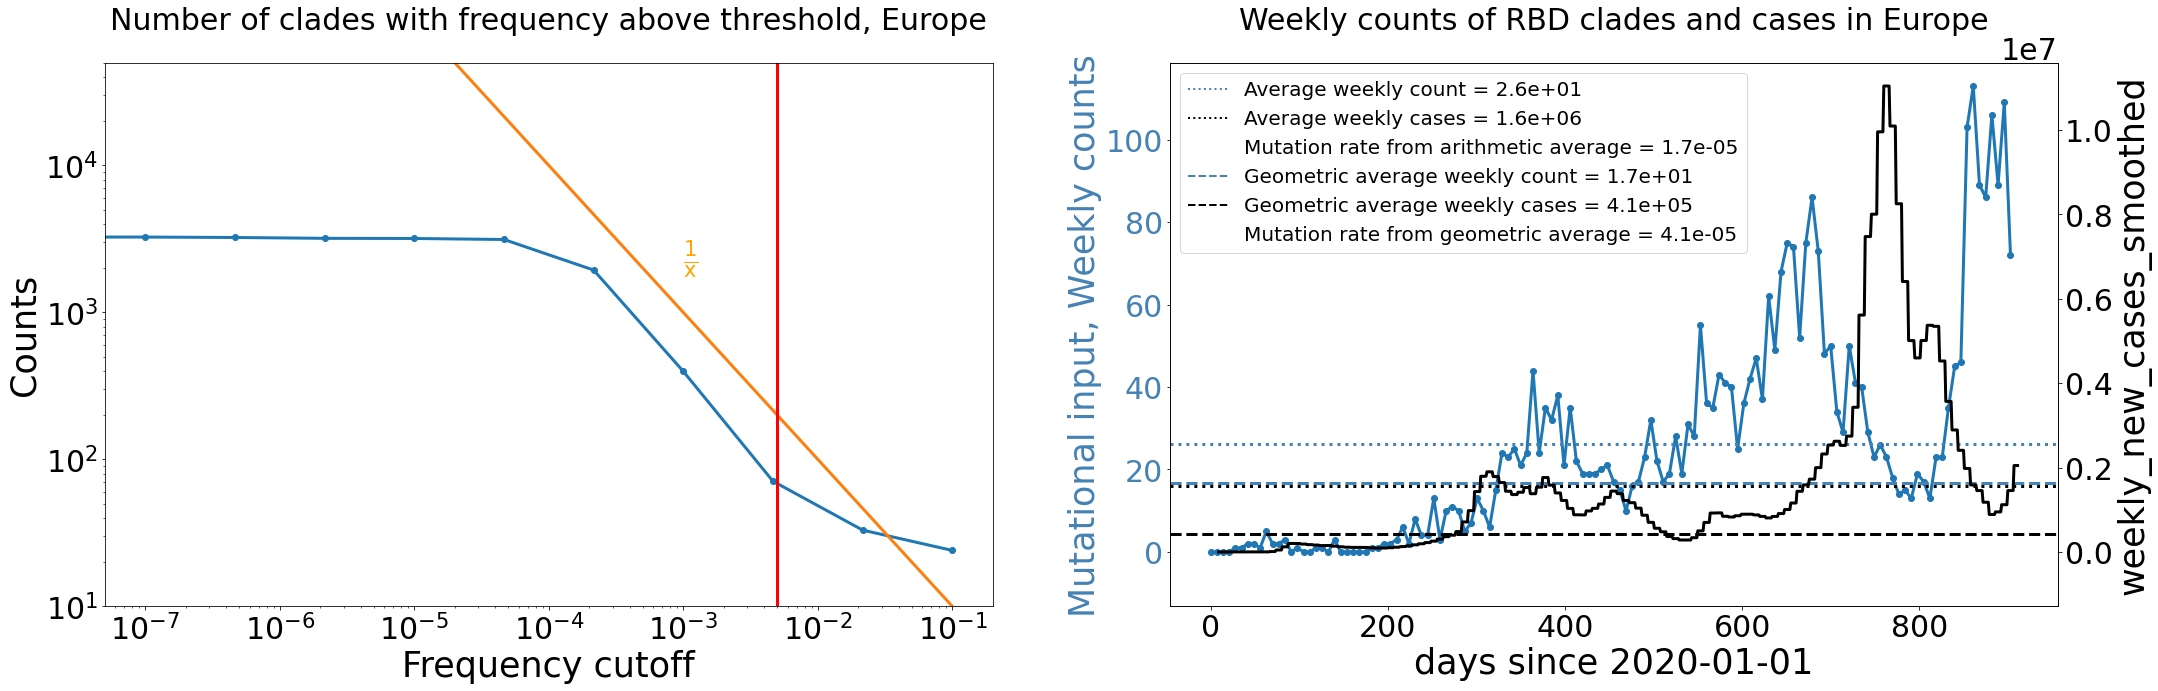

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(35,10))

plot_ax0 = True
if plot_ax0:
    ax[0].plot(xmin_vals,count_thresh,marker='o')
    ax[0].plot(xmin_vals,1/xmin_vals)
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Frequency cutoff')
    ax[0].set_ylabel('Counts')
    ax[0].annotate(r'$\frac{1}{x}$', xy=(1e-3, 2e3), xytext=(1e-3, 2e3), fontsize=30,color='orange')

    ax[0].set_ylim(bottom=1e1,top=5e4)
    ax[0].axvline(x = 5e-3,color='r')
    ax[0].set_title('Number of clades with frequency above threshold, Europe', fontsize = 30, y = 1.05)

plot_ax1 = True
if plot_ax1:
    ax[1].plot(h[:-1],b,marker='o')
    geom_avg_weekly_counts = np.exp(np.average(np.log(b[b>0])))
    geom_avg_weekly_cases = np.exp(np.average(np.log(Europe_cases)))

    lin_avg_weekly_counts = np.average(b)
    lin_avg_weekly_cases = np.average(Europe_cases)

    ax[1].axhline(lin_avg_weekly_counts,color='steelblue',ls = ':')
    ax[1].axhline(geom_avg_weekly_counts,color='steelblue',ls = '--')
    # for xmin in xmin_vals[1:3:1]:
    #     plt.hist(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = 100,histtype='step',density=True,label = f'{xmin:.1e}',lw=3);

    tax= ax[1].twinx()
    sns.lineplot(data = covid_data_Europe, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    tax.set_xlim(ax[1].get_xlim())

    mpl_axes_aligner.align.yaxes(ax[1], 0, tax, 0, 0.1)
    tax.axhline(lin_avg_weekly_cases,color='black',ls = ':')
    tax.axhline(geom_avg_weekly_cases,color='black',ls = '--')
    print(f'average weekly count: {lin_avg_weekly_counts:.1f}')
    print(f'average weekly cases: {lin_avg_weekly_cases:.1e}')
    print(f'weekly mutation rate: {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}')
    print()
    print(f'geometric average weekly count: {geom_avg_weekly_counts:.1f}')
    print(f'geometric average weekly cases: {geom_avg_weekly_cases:.1e}')
    print(f'geometric weekly mutation rate: {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}')


    handles = [
        Line2D([0], [0], color='steelblue', lw=2, ls = ':', label=f'Average weekly count = {lin_avg_weekly_counts:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = ':', label=f'Average weekly cases = {lin_avg_weekly_cases:.1e}'), 
        Line2D([0], [0], color='steelblue', lw=2, ls = '', label=f'Mutation rate from arithmetic average = {lin_avg_weekly_counts/lin_avg_weekly_cases:.1e}'),
        Line2D([0], [0], color='steelblue', lw=2, ls = '--', label=f'Geometric average weekly count = {geom_avg_weekly_counts:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = '--', label=f'Geometric average weekly cases = {geom_avg_weekly_cases:.1e}'),
        Line2D([0], [0], color='black', lw=2, ls = '', label=f'Mutation rate from geometric average = {geom_avg_weekly_counts/geom_avg_weekly_cases:.1e}'),]



    ax[1].legend(handles= handles,loc='upper left',fontsize=20)
    ax[1].set_xlabel(f'days since {reference_date.date()}')
    ax[1].set_ylabel('Mutational input, Weekly counts',color='steelblue')
    ax[1].tick_params(axis='y', labelcolor='steelblue')
    ax[1].set_title('Weekly counts of RBD clades and cases in Europe', fontsize = 30, y = 1.05)
plt.savefig(output_folder+'/weekly_counts_Europe.pdf',bbox_inches='tight')
# ax[1].set_yscale('log')

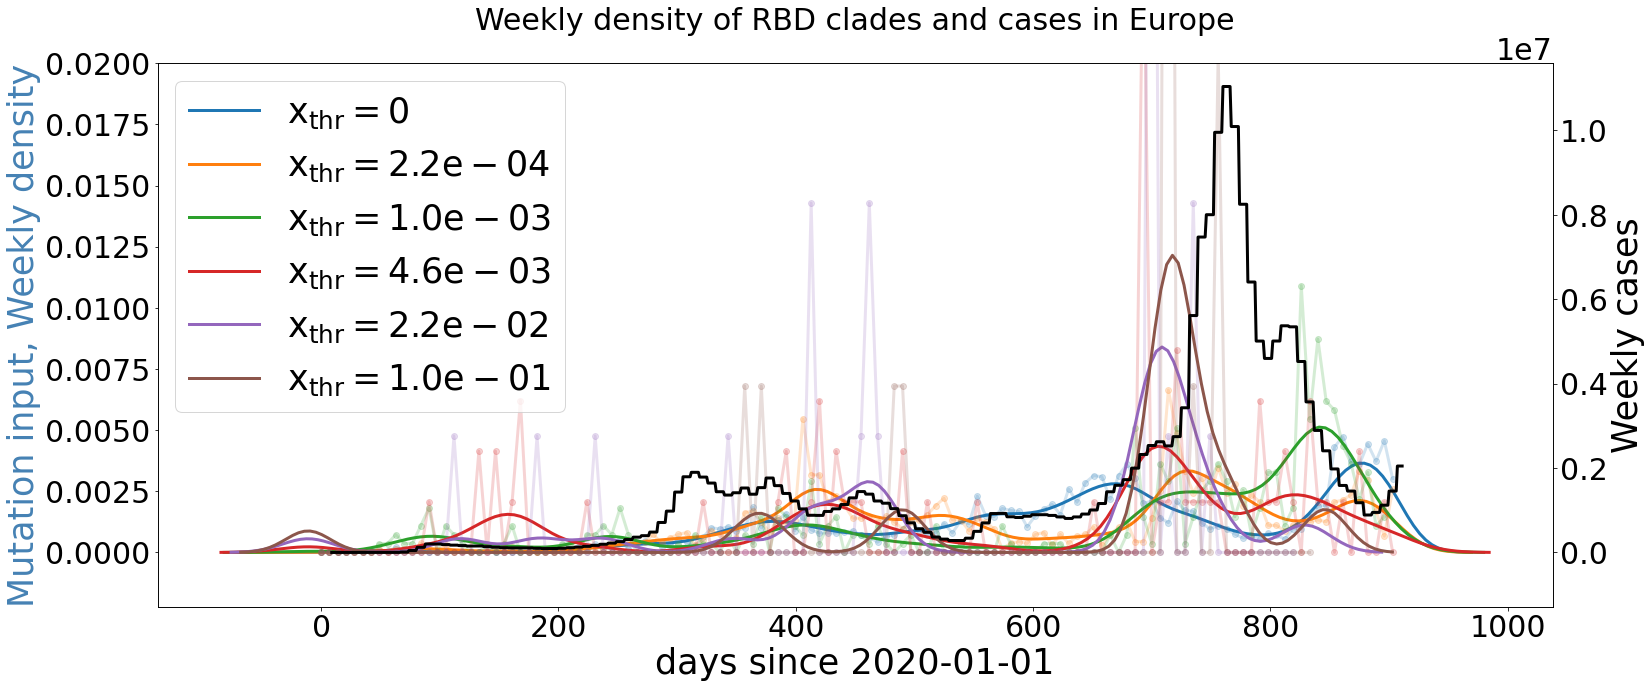

In [ ]:
fig,ax= plt.subplots(figsize=(25,10))

b_0, h_0 = np.histogram(x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
l_0, = ax.plot(h_0[:-1],b_0, marker='o', alpha=0.2)
sns.kdeplot(x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color())


for xmin in xmin_vals[6:]:
    b_xmin,h_xmin = np.histogram(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
    l_xmin, = ax.plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2)
    sns.kdeplot(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',color=l_xmin.get_color())
    # ax.plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
    # ax[0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')
ax.set_ylim(0,2e-2)
ax.legend(loc='best')

tax= ax.twinx()
sns.lineplot(data = covid_data_Europe, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
mpl_axes_aligner.align.yaxes(ax, 0, tax, 0, 0.1)

ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_ylabel('Mutation input, Weekly density',color='steelblue')

tax.set_ylabel('Weekly cases',color='black')
ax.set_title('Weekly density of RBD clades and cases in Europe', fontsize = 30, y = 1.05)

plt.savefig(output_folder+'/weekly_density_Europe.pdf',bbox_inches='tight')


In [17]:
last_date = '2023-07-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_Europe  = covid_data[covid_data['location'] == 'Europe'].query(f'date < "{last_date}"')
clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/clade_stats_SARS-CoV-2'
assert os.path.exists(clade_stats_SARS_CoV_2_folder)

clade_statistics_SARS_CoV_2_Europe = pd.read_csv(clade_stats_SARS_CoV_2_folder+'/clade_statistics_Europe.tsv', sep = '\t')
clade_statistics_SARS_CoV_2_Europe = clade_statistics_SARS_CoV_2_Europe.query(f'Time < "{last_date}"')

In [18]:
x_origination_times = []
xmin_vals =[0]+ list(np.logspace(-7,-1,10))
for xmin in tqdm(xmin_vals ):
    x_mini_df  = clade_statistics_SARS_CoV_2_Europe.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    x_origination_times.append(x_mini_df)

#concatenate with column names time_xmin
x_origination_times = pd.concat(x_origination_times,axis=1)
x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]

100%|██████████| 11/11 [00:00<00:00, 12.45it/s]


In [19]:
reference_date = pd.to_datetime('2020-01-01')
x_origination_times.reset_index(inplace=True)

for xmin in xmin_vals:
    x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(x_origination_times[f'time_{xmin:.1e}'])
    x_origination_times[f'day_diff_{xmin:.1e}'] = x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date

In [20]:
xmin_vals = np.array(xmin_vals)
Europe_cases = 7*covid_data_Europe['new_cases_smoothed']
Europe_cases = Europe_cases[Europe_cases>0]
Europe_cases = Europe_cases[~np.isinf(Europe_cases)]
Europe_cases = Europe_cases[~np.isnan(Europe_cases)]


covid_data_Europe['Time_datetime'] = pd.to_datetime(covid_data_Europe['date'])
covid_data_Europe['day_diff'] = covid_data_Europe['Time_datetime']-reference_date

covid_data_Europe['day_diff'] = covid_data_Europe['day_diff'].apply(lambda x: x.days)
covid_data_Europe['weekly_new_cases_smoothed'] = covid_data_Europe['new_cases_smoothed']*7


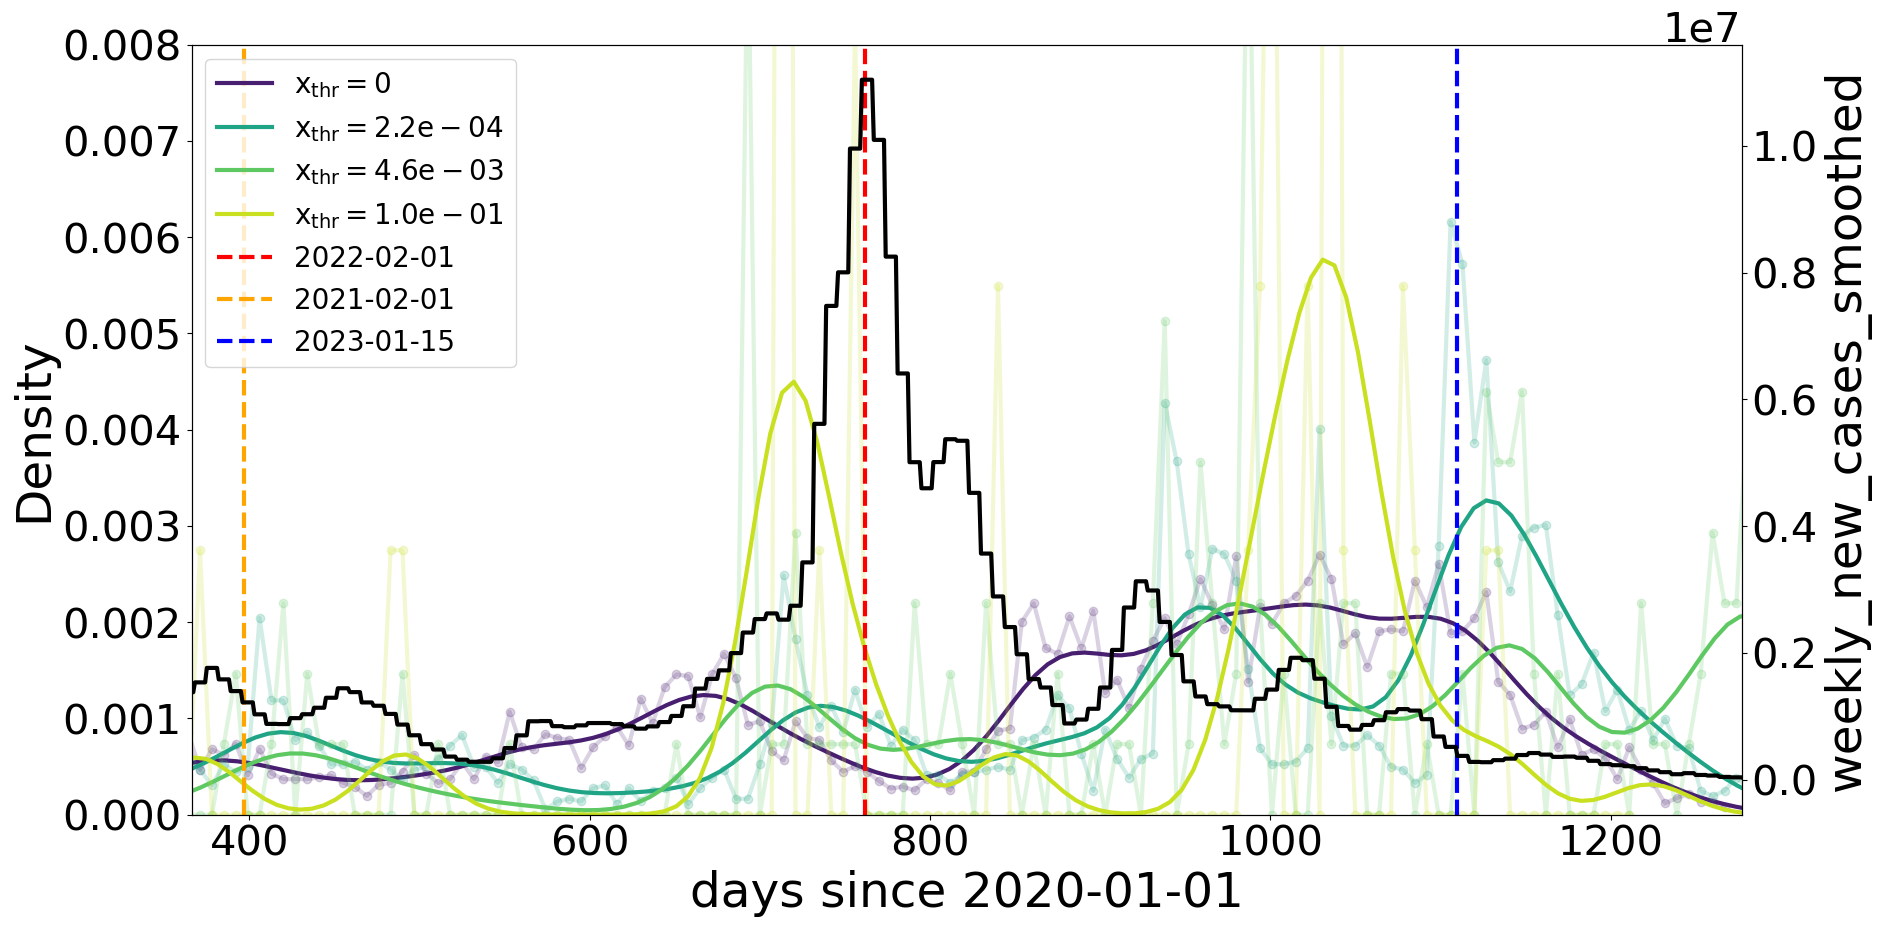

In [32]:
colors_xthresh = sns.color_palette('viridis',len(xmin_vals))

fig,ax= plt.subplots(figsize=(20,10))
b_0, h_0 = np.histogram(
    x_origination_times['day_diff_0.0e+00'].dt.days,
    bins = np.arange(0,x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)

l_0, = ax.plot(h_0[:-1],b_0, marker='o', alpha=0.2, color = colors_xthresh[0])
sns.kdeplot(x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color())

left = pd.to_datetime('2021-01-01')
right = pd.to_datetime('2023-07-01')

for xmin in xmin_vals[6::2]:
    b_xmin,h_xmin = np.histogram(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
    l_xmin, = ax.plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2, color = colors_xthresh[xmin_vals.tolist().index(xmin)])
    sns.kdeplot(x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,
                bw_method=0.1,
                label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',
                color=l_xmin.get_color())
    # ax.plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
    # ax[0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')

tax= ax.twinx()
sns.lineplot(data = covid_data_Europe, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

ax.set_xlim(left=(left-reference_date).days, right=(right-reference_date).days)

ax.axvline(x = (pd.to_datetime('2022-02-01')-reference_date).days, color='r', ls = '--', label ='2022-02-01')
ax.axvline(x = (pd.to_datetime('2021-02-01')-reference_date).days, color='orange', ls = '--', label ='2021-02-01')
ax.axvline(x = (pd.to_datetime('2023-01-15')-reference_date).days, color='blue', ls = '--', label ='2023-01-15')

ax.set_xlabel(f'days since {reference_date.date()}')

ax.set_ylim(0,8e-3)
ax.legend(loc='best',fontsize=20)

plt.savefig(output_folder+'/weekly_density_Europe_comparison.pdf',bbox_inches='tight')